# 2. Phân tích bài đăng

In [2]:
%store -r clean_df

In [3]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import plotly.express as px

## 2.1 Trong tất cả bài viết có gì?

In [4]:
text = ''
for post in clean_df['text']:
    text += str(post)
    text += " "

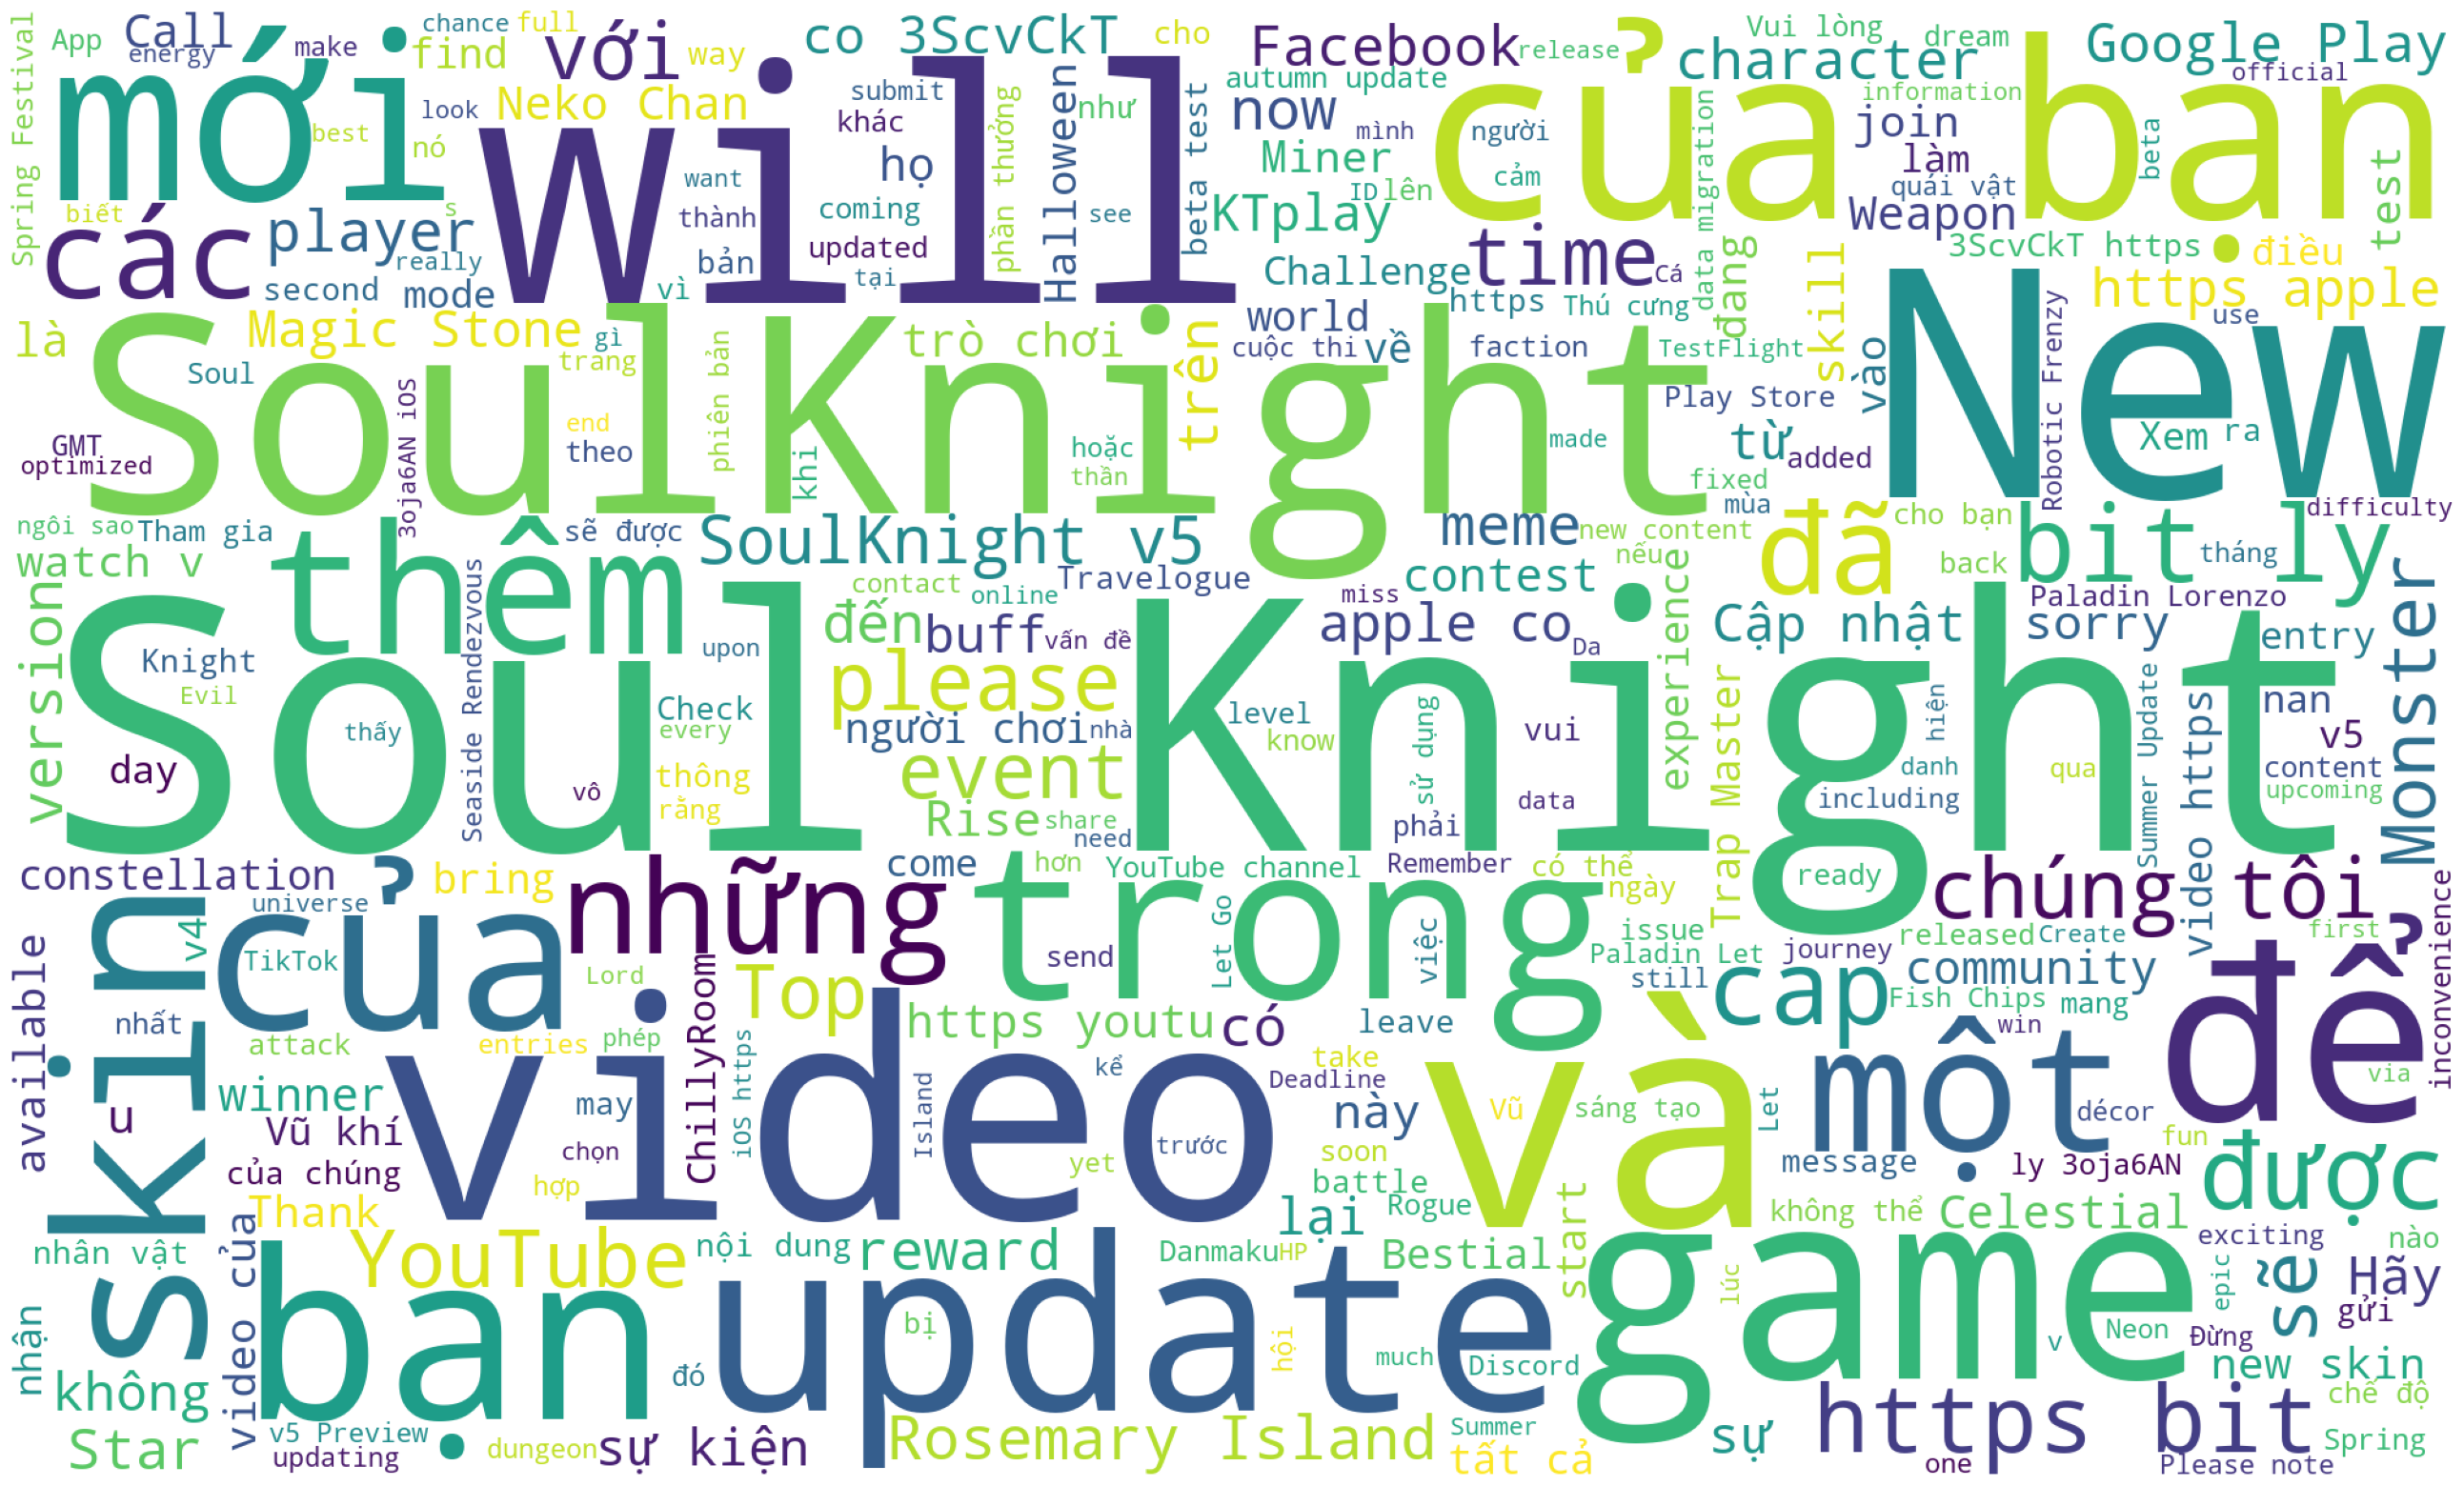

In [5]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300,
                      width=2000, height=1200
                         ).generate(text)
plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 2.2 Tần suất xuất hiện các từ đặc trưng theo thời gian

In [6]:
# Xử lý cột text và time
clean_df['text'] = clean_df['text'].astype(str)
clean_df['time'] = pd.to_datetime(clean_df['time'], format='%Y-%m-%d %H:%M:%S')
clean_df['month'] = clean_df['time'].dt.month
clean_df['year'] = clean_df['time'].dt.year

In [7]:
# Hàm tiền xử lý văn bản
def preprocess_text(text):
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s]', '', text)
    # Chuyển về chữ thường
    text = text.lower()
    return text

In [8]:
# Tạo một DataFrame mới với cột 'time', 'month', 'year' và 'text' đã được tiền xử lý
df = clean_df.copy()
df['text'] = df['text'].apply(preprocess_text)

# Tách từ và thống kê tần suất theo thời gian
df['word_counts'] = df['text'].apply(lambda x: Counter(x.split()))

# Tạo một DataFrame để lưu trữ tần suất của từng từ theo tháng và năm
time_word_freq = pd.DataFrame(index=pd.MultiIndex.from_arrays([df['year'], df['month']]))

# Điền tần suất của từng từ vào DataFrame
for word in ['update', 'skin', 'character']:
    time_word_freq[word] = df.groupby(['year', 'month'])['word_counts'].apply(lambda x: sum(d[word] for d in x))

# Sắp xếp theo thời gian
time_word_freq.sort_index(inplace=True)
time_word_freq = time_word_freq.reset_index()
time_word_freq['date'] = pd.to_datetime(time_word_freq['year'].astype(str) + '-' + time_word_freq['month'].astype(str))

time_word_freq

,year,month,update,skin,character,date
0,2019,12,0,0,1,2019-12-01
1,2020,1,0,0,0,2020-01-01
2,2020,1,0,0,0,2020-01-01
3,2020,4,0,0,0,2020-04-01
4,2020,4,0,0,0,2020-04-01
...,...,...,...,...,...,...
123,2023,10,1,1,0,2023-10-01
124,2023,10,1,1,0,2023-10-01
125,2023,11,2,1,1,2023-11-01
126,2023,11,2,1,1,2023-11-01


In [9]:
# Vẽ biểu đồ line
fig = px.line(time_word_freq, x='date', y=['update', 'skin', 'character'],
              labels={'value':'Số lượng từ', 'date':'Tháng/Năm'},
              title='Biểu đồ tần suất xuất hiện của từ theo tháng/năm')

# Chỉnh màu sắc cho mỗi loại từ
fig.update_traces(line=dict(width=2.5))
fig.update_layout(showlegend=True)

fig.show()

## 2.3 Bài đăng có số lượt tương tác cao

In [10]:
highest_react = clean_df.loc[clean_df['reaction_count'].idxmax()]
highest_react[['reaction_count', 'time']]

reaction_count                  12923
time              2021-04-09 18:40:44
Name: 111, dtype: object

In [11]:
from IPython.display import Image

hr_url = highest_react['image']
Image(url=hr_url)

In [12]:
# Sắp xếp DataFrame theo cột 'reaction_count' từ cao xuống thấp
sorted_df = clean_df.sort_values('reaction_count', ascending=False)

# Lấy ra bài đăng ở vị trí thứ hai sau khi đã sắp xếp
second_highest_react = sorted_df.iloc[1]

# Hiển thị số lượng tương tác và thời gian của bài đăng thứ hai
second_highest_react[['reaction_count', 'time', 'post_url']]

reaction_count                                                12761
time                                            2022-09-27 17:00:01
post_url          https://facebook.com/chillyroomsoulknight/post...
Name: 95, dtype: object

In [13]:
second_highest_react['post_url']

'https://facebook.com/chillyroomsoulknight/posts/5117816204994770'

## 2.4 Các loại bài đăng

In [14]:
def classify_post(row):
    if not pd.isnull(row['video']) and not pd.isnull(row['image']):
        return 'Video và Hình Ảnh'
    elif not pd.isnull(row['video']) and pd.isnull(row['image']):
        return 'Chỉ Video'
    elif not pd.isnull(row['image']):
        return 'Chỉ Hình Ảnh'
    else:
        return 'Chỉ Văn Bản'

clean_df['post_type'] = clean_df.apply(classify_post, axis=1)

post_counts = clean_df['post_type'].value_counts()

# Tạo biểu đồ tròn
fig = px.pie(values=post_counts, names=post_counts.index, title='Tỷ Lệ Các Loại Bài Đăng')

# Hiển thị biểu đồ
fig.show()

## 2.5 Bài viết có lượt share cao nhất

In [15]:
sorted_df = clean_df.sort_values('shares', ascending=False)
second_highest_react = sorted_df.iloc[1]
second_highest_react[['shares', 'time', 'post_url']]

shares                                                    533
time                                      2023-03-27 17:01:01
post_url    https://facebook.com/chillyroomsoulknight/post...
Name: 52, dtype: object

In [18]:
sorted_df = clean_df.sort_values('reaction_count', ascending=True)

# Lấy ra bài đăng ở vị trí thứ hai sau khi đã sắp xếp
lest_react = sorted_df.iloc[0]

# Hiển thị số lượng tương tác và thời gian của bài đăng thứ hai
lest_react[['reaction_count', 'time', 'post_url']]

reaction_count                                                  171
time                                            2023-11-10 10:29:58
post_url          https://facebook.com/chillyroomsoulknight/post...
Name: 2, dtype: object